classification 실습 -> Logistic Regression과 성능비교

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import sklearn
from sklearn.model_selection import train_test_split

# 0. 데이터셋 불러온 후 전처리

In [6]:
#예제 데이터 불러오기
data_url = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/titanic_train.csv")

#데이터 전처리
data_url = data_url.dropna() #결측값(잘못된 값) 제거

print(data_url.head())

#col, row에서 의미있는 값 먼저 추출
X = data_url[["Pclass", "Sex", "Age", "Fare"]]
Y = data_url["Survived"]

#데이터를 딥러닝에 사용가능하도록 One-Hot Encoding하기-> Sex항목을 Male/Female로 나누는과정
#Sex항목이 '범주형' 자료이기에 이를 숫자형 자료로 바꾸는 One-Hot encoding적용
X = pd.get_dummies(X, columns=["Sex"], dtype='int').values
Y = Y.values #values를 적용하면 numpy형태로 자료형이 바뀜

#훈련용/평가용 데이터로 나누기
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C103        S  


In [5]:
#코드가 잘 나뉘어졌는지 확인해보자
print(X_train[:5])
print(Y_train[:5])

[[ 1.     38.     90.      0.      1.    ]
 [ 2.     36.5    26.      0.      1.    ]
 [ 1.     37.     52.5542  0.      1.    ]
 [ 1.     24.     49.5042  1.      0.    ]
 [ 1.     45.     83.475   0.      1.    ]]
[1 0 1 1 0]


# 1. Logistic Regression으로 고전 분석 해보기

In [7]:
from sklearn.linear_model import LogisticRegression

LR_model = LogisticRegression()

LR_model.fit(X_train, Y_train)
#해당 모듈은 매우 잘 만들어져서 위 코드로 학습이 끝낫음....

LogisticRegression()

# 2. 딥러닝 하기 -> Neural Network(FC Layers)

In [44]:
#명세서에 나와있는 모델 설계하기
#input은 5개, output는 2개
#레이어 3개 만들며, (5,10) -> ReLU -> (10,5) -> ReLU -> (5, 2) -> Softmax

#첫번째로 딥러닝용 데이터셋 전처리 하기
class My_Titanic_Dataset(Dataset):
    def __init__(self, x_data, y_data): #생성자 및 데이터 자료형 변경
        self.x_data = torch.tensor(x_data, dtype=torch.float32)
        self.y_data = torch.tensor(y_data, dtype=torch.long)

    def __getitem__(self, index): #위치에 있는 값을 호출하는 메서드 함수
        return self.x_data[index], self.y_data[index]
    
    def __len__(self): #전체 데이터 사이즈를 측정하는 메서드 함수
        return self.x_data.shape[0]
    
dataset = My_Titanic_Dataset(X_train, Y_train)

In [43]:
#딥러닝 모델 설계하기

class My_classification_Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(in_features=5, out_features=10)
        self.fc2 = nn.Linear(in_features=10, out_features=5)
        self.fc3 = nn.Linear(in_features=5, out_features=2)

    def forward(self, x): #레이어 전사 설계
        x = self.fc1(x)
        x = F.relu(x)  #위 두문장을 하나로 쓰려면 x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        return x
    
#모델 인스턴스화
ex_model = My_classification_Model()

In [45]:
#Loss Function 및 Optimizer 선언하기

Loss_fn = nn.CrossEntropyLoss() #CEL을 써서 변수명을 criterion이라 하기도함?
Optimizer = torch.optim.Adam(ex_model.parameters(), lr=0.001)

In [46]:
#앞에서 전처리한 raw데이터를 딥러닝용 데이터로 전처리 수행하기
#Batch 사이즈는 10으로 설정해서 딥러닝용 데이터로 처리한다.

dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)

In [47]:
#CPU로 학습기 돌려보기
#시간 측정을 위한 모듈로 tqdm을 추가한다
from tqdm import tqdm

losses = [] #아래 학습된 값들 시각화 하려고 미리 빼둔 변수임

for epoch in tqdm(range(100)):
    for i, (x, y) in enumerate(dataloader):
        #Forward(전사)과정
        y_pred = ex_model(x)
        loss = Loss_fn(y_pred, y)
        losses.append(loss.item())

        #Backward 과정
        Optimizer.zero_grad() #옵티마이저 초기화
        loss.backward()

        Optimizer.step() #모델 파라미터 업데이트

        #여기부터는 딥러닝 10번째 데이터마다 훈련과정을 보기 위한 작업이라 보면 됨
        if (epoch+1) % 10 == 0 and (i % 10 == 0 and i != 0):
            print("에포크 : %d, 배치 : %d, 로스결과 : %.4f" % (epoch+1, i, loss.item()))

 15%|█▌        | 15/100 [00:00<00:02, 41.25it/s]

에포크 : 10, 배치 : 10, 로스결과 : 0.6234


 24%|██▍       | 24/100 [00:00<00:02, 33.59it/s]

에포크 : 20, 배치 : 10, 로스결과 : 0.4163


 32%|███▏      | 32/100 [00:01<00:02, 27.07it/s]

에포크 : 30, 배치 : 10, 로스결과 : 0.5045


 44%|████▍     | 44/100 [00:01<00:02, 22.51it/s]

에포크 : 40, 배치 : 10, 로스결과 : 0.3367


 53%|█████▎    | 53/100 [00:02<00:02, 19.75it/s]

에포크 : 50, 배치 : 10, 로스결과 : 0.5113


 62%|██████▏   | 62/100 [00:02<00:01, 19.34it/s]

에포크 : 60, 배치 : 10, 로스결과 : 0.4646


 72%|███████▏  | 72/100 [00:03<00:01, 20.25it/s]

에포크 : 70, 배치 : 10, 로스결과 : 0.4635


 84%|████████▍ | 84/100 [00:03<00:00, 23.43it/s]

에포크 : 80, 배치 : 10, 로스결과 : 0.5469


 93%|█████████▎| 93/100 [00:04<00:00, 20.03it/s]

에포크 : 90, 배치 : 10, 로스결과 : 0.4388


100%|██████████| 100/100 [00:04<00:00, 22.84it/s]

에포크 : 100, 배치 : 10, 로스결과 : 0.3605


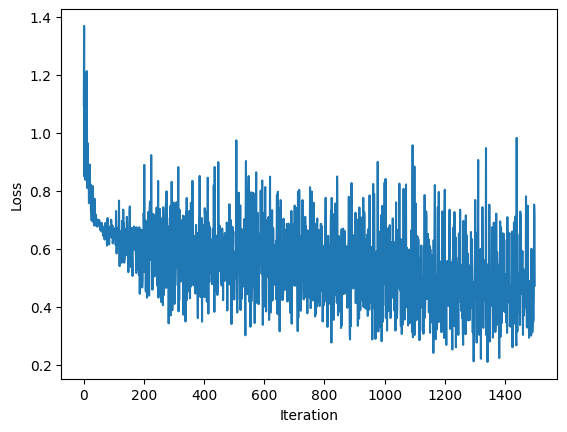

In [48]:
#학습된 값들을 시각화 해보자
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel("Loss")
plt.show() #이게 Loss를 minimize해야 하는것이 목표이기에 갈수록 값이 0으로 떨어져야 정상임
#다시 돌리니까 수렴은 하긴 함... #근데 좀 이상한데 ㅋㅋㅋㅋ...

# 3. 모델 평가히기 </br>
(LR모델이랑 NN모델 평가 수행)

In [50]:
#LR모델(Logistic Regression Model)평가를 위한 코드

from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report

Y_pred = LR_model.predict(X_test)

print("정확도(Accuracy) : ", accuracy_score(Y_pred, Y_test))
print("정밀도(Precision) : ", precision_score(Y_pred, Y_test))
print("재현율(Recall) : ", recall_score(Y_pred, Y_test))
print("조화평균(f1) : ", f1_score(Y_pred, Y_test))

print(classification_report(Y_pred, Y_test))

정확도(Accuracy) :  0.8108108108108109
정밀도(Precision) :  0.76
재현율(Recall) :  0.95
조화평균(f1) :  0.8444444444444444
              precision    recall  f1-score   support

           0       0.92      0.65      0.76        17
           1       0.76      0.95      0.84        20

    accuracy                           0.81        37
   macro avg       0.84      0.80      0.80        37
weighted avg       0.83      0.81      0.81        37



In [51]:
#딥러닝 (nn)모델의 평가를 위한 코드

NN_Y_pred = []

#딥러닝 결과값은 tensor자료형이니 numpy로 바꿔줘야함

#일단 model.eval()이랑 같은 기능을 하는 구문임...
with torch.no_grad(): #이거는 model.eval()이랑 좀 확인해봐야 하는 것임...
    for x, y in zip(X_test, Y_test):
        outputs = ex_model(torch.tensor([x], dtype=torch.float32))
        _, predicted = torch.max(outputs.data, 1)
        NN_Y_pred.append(predicted.detach().cpu().item())

print("정확도(Accuracy) : ", accuracy_score(NN_Y_pred, Y_test))
print("정밀도(Precision) : ", precision_score(NN_Y_pred, Y_test))
print("재현율(Recall) : ", recall_score(NN_Y_pred, Y_test))
print("조화평균(f1) : ", f1_score(NN_Y_pred, Y_test))

print(classification_report(NN_Y_pred, Y_test))

정확도(Accuracy) :  0.7297297297297297
정밀도(Precision) :  0.84
재현율(Recall) :  0.7777777777777778
조화평균(f1) :  0.8076923076923077
              precision    recall  f1-score   support

           0       0.50      0.60      0.55        10
           1       0.84      0.78      0.81        27

    accuracy                           0.73        37
   macro avg       0.67      0.69      0.68        37
weighted avg       0.75      0.73      0.74        37



C:\Users\Z13_ASH\AppData\Local\Temp\ipykernel_52716\2711436867.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:277.)
  outputs = ex_model(torch.tensor([x], dtype=torch.float32))
